In [87]:
import torch
import math
import matplotlib.pyplot as plt
from transformer_lens import HookedTransformer
from muutils.dictmagic import condense_tensor_dict

In [84]:
def normalize(R):
    with torch.no_grad():
        mean = R.mean(dim=0)
        R = R - mean
        norms = torch.norm(R, p=2, dim=1, keepdim=True)
        R = R/norms
    return R

def cal_cov(R):
    with torch.no_grad():
        Z = torch.nn.functional.normalize(R, dim=1)
        A = torch.matmul(Z.T, Z)/Z.shape[0]
    return A

def cal_entropy(A):
    with torch.no_grad():
        eig_val = torch.svd(A / torch.trace(A))[1] 
        entropy = - (eig_val * torch.log(eig_val)).nansum().item()
        normalized_entropy = entropy/math.log(A.shape[0])
    return normalized_entropy


In [89]:
prompt = "Hi Generative AI"
#MODEL: HookedTransformer = HookedTransformer.from_pretrained("tiny-stories-3M")
MODEL: HookedTransformer = HookedTransformer.from_pretrained("gpt2")
TOKENIZER = MODEL.tokenizer

input_ids = TOKENIZER.encode(prompt)
logits, cache = MODEL.run_with_cache(
    prompt,
)

Loaded pretrained model gpt2 into HookedTransformer


In [70]:
d_model: int = MODEL.cfg.d_model
n_layers: int = MODEL.cfg.n_layers
n_heads: int = MODEL.cfg.n_heads
d_vocab: int = MODEL.cfg.d_vocab
print(f"{d_model=}, {n_layers=}, {n_heads=}, {d_vocab=}")

d_model=768, n_layers=12, n_heads=12, d_vocab=50257


In [71]:
print(input_ids)
print(MODEL(torch.tensor(input_ids)).shape)
print(MODEL(prompt).shape)
print(condense_tensor_dict(cache, return_format="yaml"))

[31373, 9552]
torch.Size([1, 2, 50257])
torch.Size([1, 3, 50257])
blocks:
  '[0-11]':
    ln1:
      hook_scale: (1, 3, 1)
      hook_normalized: (1, 3, 768)
    attn:
      '[hook_q, hook_k, hook_v, hook_z]': (1, 3, 12, 64)
      '[hook_attn_scores, hook_pattern]': (1, 12, 3, 3)
    ln2:
      hook_scale: (1, 3, 1)
      hook_normalized: (1, 3, 768)
    mlp:
      '[hook_pre, hook_post]': (1, 3, 3072)
    '[hook_resid_pre, hook_attn_out, hook_resid_mid, hook_mlp_out, hook_resid_post]': (1,
      3, 768)
ln_final:
  hook_scale: (1, 3, 1)
  hook_normalized: (1, 3, 768)
'[hook_embed, hook_pos_embed]': (1, 3, 768)



In [90]:
layers = []
firstLayer = "blocks.0.hook_resid_post"

for i in range(12):
    new_string = firstLayer.replace("0", str(i))
    layers.append(new_string)

Entropy = []

for i in range(12):
   with torch.no_grad():
      R = cache[layers[i]][0]
      R = normalize(R)
      A = cal_cov(R)
      Entropy.append(cal_entropy(A))

print(Entropy)

[0.16185896957746612, 0.04159574133474004, 0.0054498561423353955, 0.005966365148985502, 0.006326440093628474, 0.00696839397882347, 0.007577125342077018, 0.008999961568819936, 0.010733194836805883, 0.012415467840080832, 0.015505126494704664, 0.18793792148996763]


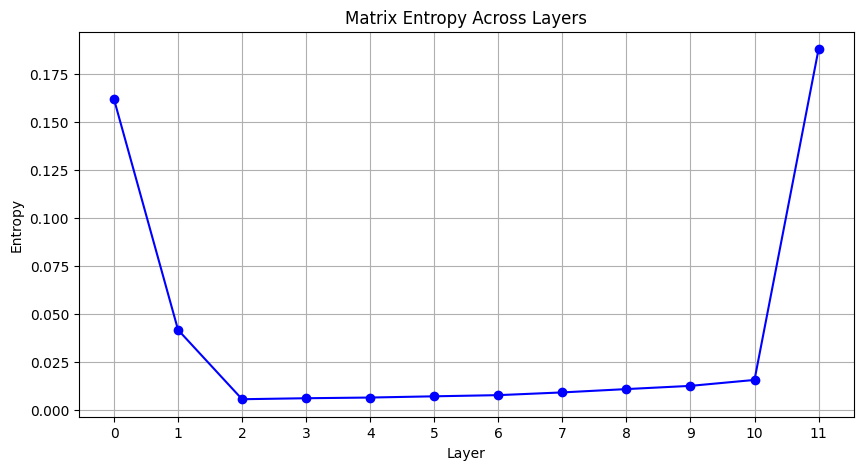

In [91]:
x_values = list(range(len(Entropy)))

plt.figure(figsize=(10, 5)) 
plt.plot(x_values, Entropy, marker='o', linestyle='-', color='b')  
plt.title('Matrix Entropy Across Layers')
plt.xlabel('Layer') 
plt.ylabel('Entropy')  
plt.grid(True) 
plt.xticks(x_values) 
plt.show()

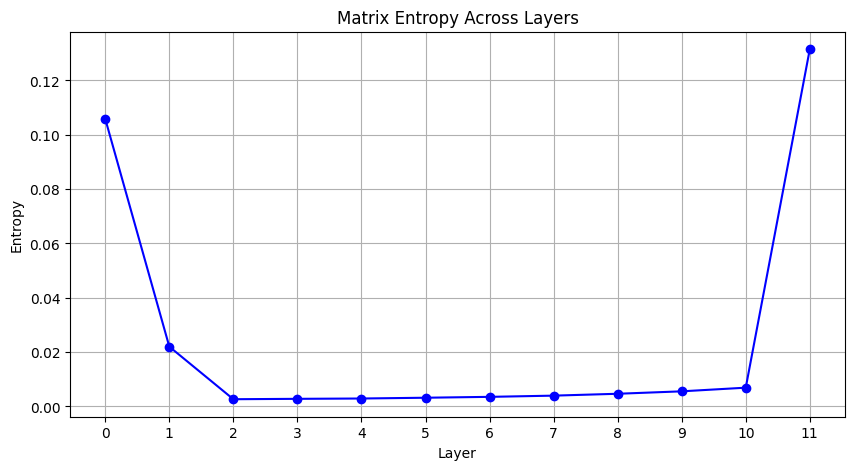

In [88]:
x_values = list(range(len(Entropy)))

plt.figure(figsize=(10, 5)) 
plt.plot(x_values, Entropy, marker='o', linestyle='-', color='b')  
plt.title('Matrix Entropy Across Layers')
plt.xlabel('Layer') 
plt.ylabel('Entropy')  
plt.grid(True) 
plt.xticks(x_values) 
plt.show()